<a href="https://colab.research.google.com/github/Entro01/ML-starter/blob/main/makemore/makemore_MLP/makrmore_MLP_v5_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
# building the vocabulary of characters

chrs = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [10]:
# building the dataset

block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [12]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # no. of neurons in the hiddlen layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator = g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator = g)
B1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn(n_hidden, vocab_size, generator = g)
B2 = torch.randn(vocab_size, generator = g)

parameters= [C, W1, B1, W2, B2]
print(sum(p.nelement() for p in parameters)) # total parameters

for p in parameters:
  p.requires_grad = True

11897


In [14]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creating a mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], block_size * n_embd) # concatenating vectors
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print("loss: ", loss.item())

      0/ 200000: 25.2591
  10000/ 200000: 2.2697
  20000/ 200000: 2.2711
  30000/ 200000: 2.3628
  40000/ 200000: 2.1558
  50000/ 200000: 2.2201
  60000/ 200000: 2.1141
  70000/ 200000: 2.5201
  80000/ 200000: 2.4942
  90000/ 200000: 2.6254
 100000/ 200000: 2.2516
 110000/ 200000: 1.7503
 120000/ 200000: 2.1313
 130000/ 200000: 2.2110
 140000/ 200000: 1.9866
 150000/ 200000: 2.2935
 160000/ 200000: 1.8594
 170000/ 200000: 2.0378
 180000/ 200000: 2.1389
 190000/ 200000: 1.8592
loss:  2.431771755218506


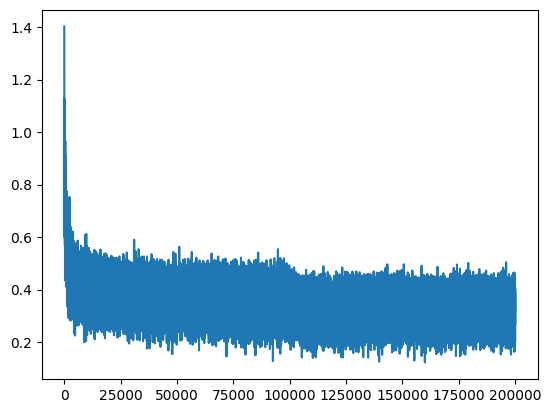

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], block_size * n_embd) # concatinating vectors
  hpreact = embcat @ W1 + B1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + B2 # output layer
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.124290943145752
val 2.1758646965026855
